In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

#### Pick Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
#using data from Yahoo, with date starting from January 2018
path_name=r'/home/mmech/stocks_csv/'
def Stockloader(csv_name,path_name):
    orig_data=pd.read_csv(path_name+ csv_name)
    dates=orig_data['Date']
    
    orig_data['TypPrice']=  (orig_data['High'] + orig_data['Low'] + orig_data['Close'] ) /3

            
    pre_data=orig_data.drop(['Date','Adj Close'],axis=1)
    
    
    labels=pre_data.columns
    scaler=MinMaxScaler(feature_range=(-1,1))
    scaled_data=scaler.fit_transform(pre_data)
    data=pd.DataFrame(scaled_data,columns=labels)

    return data, dates, scaler

orig_data=pd.read_csv('MSFTmod.csv')
pre_data=orig_data.drop(['date','Unnamed: 0','vwap'],axis=1) #remove vol and change due to unpredictable nature
labels=pre_data.columns

scaler=MinMaxScaler(feature_range=(-1,1))
scaled_data=scaler.fit_transform(pre_data)
data=pd.DataFrame(scaled_data,columns=labels)

train_data= data[0:round(0.8*data.shape[0])]  #80% of first data will be for training
test_data= data[round(0.8*data.shape[0]):]
test_data=test_data.reset_index().drop('index',axis=1)

### Insert stock_csv file here

In [5]:
csv_name=r'MRSN.csv'
data, dates, scaler= Stockloader(csv_name,path_name) #type the name of the stock.csv file here
#vwap_ind= test_data.columns.get_loc('vwap')
typ_ind=data.columns.get_loc('TypPrice')
high_ind= data.columns.get_loc('High')
low_ind=data.columns.get_loc('Low')
data.head()

,Open,High,Low,Close,Volume,TypPrice
0,0.353100,0.402726,0.429165,0.452392,-0.997202,0.449603
1,0.433064,0.363714,0.432751,0.426879,-0.997238,0.428222
2,0.447439,0.380750,0.437470,0.410478,-0.995874,0.430360
3,0.363881,0.404600,0.399717,0.406834,-0.998060,0.425473
4,0.347709,0.307496,0.367626,0.362187,-0.996625,0.365302


#### Hyperparameters

In [6]:
num_pred=4
sample_len=4
hidden_size=120
num_layers=1
batch_size=1
learning_rate=0.0085
num_epochs= 70 #100
dropout=0.05
weight_decay=0.0001

In [7]:
def Extract_XY(data,train_ratio): 

    if num_pred>sample_len:
        print('Error')
    else:
    
        chunk_list=[]
        chunk_len=sample_len + num_pred 

        num_targets=len(data)-chunk_len

        for timestep in range(num_targets):
            end_index=chunk_len+timestep
            chunk_list.append(data.iloc[timestep:end_index,:].values)

        chunks=np.array(chunk_list)

        train_data=chunks[:round(train_ratio*data.shape[0])]
        test_data=chunks[round(train_ratio*data.shape[0]):]

        train_inputs=train_data[:,:-num_pred,:]
        train_targets=train_data[:,-num_pred:,:]

        test_inputs=test_data[:,:-num_pred,:]
        test_targets=test_data[:,-num_pred:,:]

    return train_inputs,train_targets, test_inputs, test_targets

In [8]:
def Tensify(data,train_ratio):
    tensor_list=[]
    train_inputs, train_targets, test_inputs, test_targets = Extract_XY(data,train_ratio)
    
    data_list=[train_inputs,train_targets,test_inputs,test_targets]
    
    for data in data_list:
        tensor_list.append(torch.Tensor(data)) 
        
    train_inputs=tensor_list[0]
    train_targets=tensor_list[1]
    test_inputs=tensor_list[2]
    test_targets=tensor_list[3]
    
    return train_inputs,train_targets,test_inputs,test_targets

In [9]:
train_inputs, train_targets, test_inputs, test_targets= Tensify(data,0.8)

#input dimensions= (num_samples,sample_len, num_features), output dimensions= (num_samples,num_features)
print(train_inputs.shape,train_targets.shape,test_inputs.shape,test_targets.shape)

torch.Size([515, 4, 6]) torch.Size([515, 4, 6]) torch.Size([121, 4, 6]) torch.Size([121, 4, 6])


class StockDataset(torch.utils.data.Dataset):
    def __init__(self,inputs, targets):
        super(StockDataset).__init__()
        self.inputs=inputs
        self.targets=targets
    
    def __getitem__(self,idx):
        return self.inputs[idx], self.targets[idx]
    
    def __len__(self):
        return len(self.inputs)

training_dataset=torch.utils.data.TensorDataset(train_inputs,train_targets)
testing_dataset=torch.utils.data.TensorDataset(test_inputs,test_targets)
training_loader=DataLoader(training_dataset,batch_size=batch_size,shuffle=True)
testing_loader=DataLoader(testing_dataset,batch_size=batch_size,shuffle=True)


train_dataset=StockDataset(train_inputs,train_targets)
test_dataset=StockDataset(test_inputs,test_targets)
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [10]:
#lstm
class net(nn.Module):
    def __init__(self,hidden_size,num_layers,dropout,batch_first=True):#batch_first=True
        super(net,self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.input_size=train_inputs.shape[2] #number of features
        self.output_size= self.input_size #should = input_size
        
        self.dropout=nn.Dropout(dropout)
        self.lstm=nn.LSTM(self.input_size,self.hidden_size,self.num_layers,batch_first)
        self.linear=nn.Linear(self.hidden_size, self.output_size) #hidden is the input to this function
        
    def init_states(self, inputs):
        hidden=torch.zeros(self.num_layers,train_inputs.shape[1], self.hidden_size).to(device)
        cell= torch.zeros(self.num_layers, train_inputs.shape[1], self.hidden_size).to(device)
        return hidden, cell
    
    def forward(self, inputs,hidden, cell):
        output, (hidden,cell) =self.lstm(inputs, (hidden.detach(), cell.detach()))
        output= self.dropout(output)
        output= self.linear(output[:,-num_pred:,]) #shape has to be the same as target shape
        return output,(hidden,cell)

model=net(hidden_size, num_layers,dropout)
model.to(device)

net(
  (dropout): Dropout(p=0.05, inplace=False)
  (lstm): LSTM(6, 120)
  (linear): Linear(in_features=120, out_features=6, bias=True)
)

#### Training and Evaluation Steps

In [11]:
##pick optimizer and loss function
loss_func = nn.MSELoss()
optimizer  = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

In [12]:
def train_step(inputs, targets):
    hidden, cell= model.init_states(inputs) #can choose to keep updating a new one
    
    model.zero_grad()
    loss=0
    
    output, (hidden, cell)= model(inputs,hidden,cell)
    loss=loss_func(output,targets)
    
    loss.backward()#(retain_graph=True)
    optimizer.step()
    
    avg_loss=loss/sample_len
    
    return avg_loss, output, (hidden,cell)

In [13]:
def stateless_step(inputs,targets, hidden, cell): 
    
    loss=0
    model.eval()

    hidden, cell=model.init_states(test_inputs) #don't initialize if u want stateful

    
    #for test_inputs, test_targets in test_loader:
        #test_inputs,test_targets=test_inputs.to(device), test_targets.to(device)
    
     
    evals, (hidden,cell)= model(test_inputs, hidden, cell) 
    
    loss=loss_func(evals,targets)
    
    avg_loss=loss/sample_len/len(targets)
    
    
    return evals, avg_loss

In [14]:
def stateful_step(inputs,targets,hidden, cell): 
    
    loss=0
    
    model.eval()

    #hidden, cell=model.init_states(test_inputs) #don't initialize if u want stateful

    
    #for test_inputs, test_targets in test_loader:
        #test_inputs,test_targets=test_inputs.to(device), test_targets.to(device)
    
     
    evals, (hidden,cell)= model(inputs, hidden, cell) 
    
    loss=loss_func(evals,targets)
    
    avg_loss=loss/sample_len/len(targets)
    
    return evals, avg_loss

In [15]:
train_inputs,train_targets,test_inputs,test_targets=train_inputs.to(device),train_targets.to(device),test_inputs.to(device),test_targets.to(device)
train_losses=[]
loss_sum=0
for epoch in range(num_epochs):
    #for train_inputs, train_targets in train_loader:
    #for train_inputs, train_targets in training_loader:
    #train_inputs,train_targets=train_inputs.to(device),train_targets.to(device)
    avg_loss, output, (hidden,cell)=train_step(train_inputs,train_targets)
    loss_sum+=avg_loss
    if (epoch % 5) == 4: 
        train_losses.append(loss_sum/5)
        loss_sum=0

ful_evals, ful_loss=stateful_step(test_inputs,test_targets,hidden, cell)
less_evals, less_loss=stateless_step(test_inputs,test_targets,hidden, cell)

Text(0.5, 1.0, 'Training Loss Over Epochs')

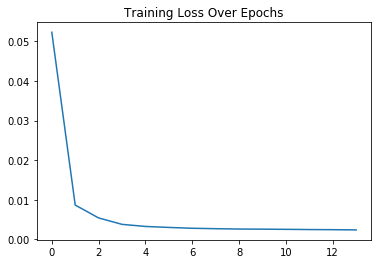

In [16]:
plt.plot(train_losses)
plt.title('Training Loss Over Epochs')

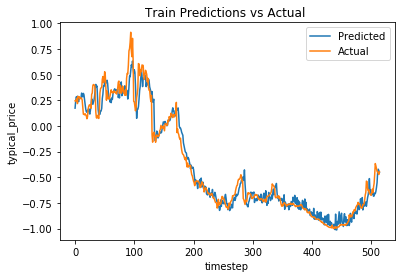

In [17]:
plt.title('Train Predictions vs Actual ')
plt.plot(output[:,-1,high_ind].cpu().detach().numpy(), label="Predicted")
plt.plot(train_targets[:,-1,high_ind].cpu().detach().numpy(),label='Actual')
plt.ylabel('typical_price')
plt.xlabel('timestep')
plt.legend()
plt.show()

In [18]:
def ScatterTime(evals,test_targets):
    empty=[]
    for i in evals[::num_pred]:
        for t in range(len(i)):
            empty.append(i[t])

    abyss=[]
    for i in test_targets[::num_pred]:
        for t in range(len(i)):
            abyss.append(i[t])

    void=torch.Tensor([t.cpu().detach().numpy() for t in empty])
    nothing=torch.Tensor([g.cpu().detach().numpy() for g in abyss])
    return void, nothing

In [19]:
sctrful_evals, sctr_targets=ScatterTime(ful_evals,test_targets)
sctrless_evals, sctr_targets=ScatterTime(less_evals,test_targets)

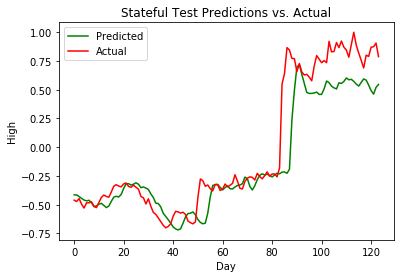

In [20]:
plt.title('Stateful Test Predictions vs. Actual')
#plt.plot(restored_evals[:,high_ind], 'g',label='Predicted')
#plt.plot(restored_test_targets[:,high_ind],'r',label='Actual')
plt.plot(sctrful_evals[:,high_ind].cpu().detach().numpy(), 'g',label='Predicted')
plt.plot(sctr_targets[:,high_ind].cpu().detach().numpy(), 'r',label='Actual')
plt.ylabel('High')
plt.xlabel('Day')
plt.legend()
plt.show()

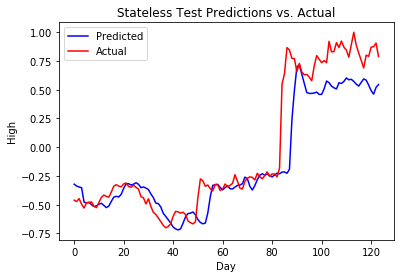

In [21]:
plt.title('Stateless Test Predictions vs. Actual')
#plt.plot(restored_evals[:,high_ind], 'g',label='Predicted')
#plt.plot(restored_test_targets[:,high_ind],'r',label='Actual')
plt.plot(sctrless_evals[:,high_ind].cpu().detach().numpy(), 'b',label='Predicted')
plt.plot(sctr_targets[:,high_ind].cpu().detach().numpy(), 'r',label='Actual')
plt.ylabel('High')
plt.xlabel('Day')
plt.legend()
plt.show()

In [22]:
if ful_loss > less_loss:
    print('Stateless model is better')
    print(less_loss)
else:
    print('Stateful model is better')
    print(ful_loss)

Stateful model is better
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)


In [23]:
def StockPredictor(train_inputs,data,hidden,cell,csv_name): 
    
    retrain=torch.Tensor(data[-sample_len:].values).to(device)
    
    if ful_loss > less_loss:
        hidden,cell=model.init_states(train_inputs)
        
    pred, (hidden,cell)=model(retrain.view(-1,retrain.shape[0],retrain.shape[1]),hidden,cell)
    rescaled_pred=scaler.inverse_transform(pred.view(pred.shape[1],pred.shape[2]).cpu().detach())
    
    high=rescaled_pred[:,high_ind]
    low=rescaled_pred[:,low_ind]
    
    for day in range(len(high)):
        if day<high.shape[0]-1:
            
            if high[day] > high[day+1]:
                print('Sell for day',day,'at',high[day])
            elif high[day] == high[day+1]:
                print('Hold for day',day)
            elif high[day] < high[day+1]:
                print('Hold/buy for day',day,'at',low[day])        
            else:
                break
    
    plt.title('Stock Forecast for'+ ' '+ csv_name)
    plt.plot(high)
    plt.ylabel(data.columns[high_ind])
    plt.xlabel('Day')

Sell for day 0 at 17.563966364540637
Sell for day 1 at 17.54174098494731
Hold/buy for day 2 at 15.762716030329466


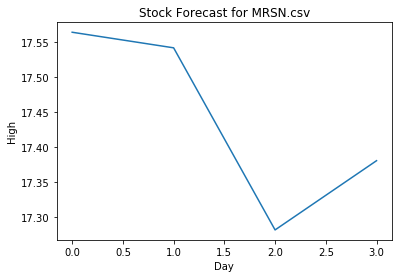

In [24]:
StockPredictor(train_inputs,data,hidden,cell,csv_name)